In [1]:
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import pickle

from utils.accuracy_95 import my_eval, loss_and_acc, load_history, compare

data_dir = "weights/"

In [2]:
def create_bench_model():
    inputs = Input(shape = (32,32,3))
    x = Conv2D(64,(3,3),padding = "SAME",activation= "relu")(inputs)
    x = Conv2D(64,(3,3),padding = "SAME",activation= "relu")(x)
    x = Dropout(0.25)(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128,(3,3),padding = "SAME",activation= "relu")(x)
    x = Conv2D(128,(3,3),padding = "SAME",activation= "relu")(x)
    x = Dropout(0.25)(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256,(3,3),padding = "SAME",activation= "relu")(x)
    x = Conv2D(256,(3,3),padding = "SAME",activation= "relu")(x)
    x = GlobalAveragePooling2D()(x)

    x = Dense(1024,activation = "relu")(x)
    x = Dropout(0.25)(x)
    y = Dense(10,activation = "softmax")(x)
    return Model(inputs, y)

In [3]:
(x_train_raw, y_train_raw), (x_test_raw,y_test_raw) = cifar10.load_data()
y_train = to_categorical(y_train_raw)
y_test = to_categorical(y_test_raw)
x_train = x_train_raw / 255
x_test  = x_test_raw / 255

In [25]:
batch_size = 500
epochs = 150
steps_per_epoch = x_train.shape[0] // batch_size
validation_steps = y_test.shape[0] // batch_size

Epoch 1/30
100/100 [==============================] - 11s 104ms/step - loss: 2.1925 - accuracy: 0.1657 - val_loss: 1.9571 - val_accuracy: 0.2612
Epoch 2/30
100/100 [==============================] - 10s 103ms/step - loss: 1.7631 - accuracy: 0.3305 - val_loss: 1.5172 - val_accuracy: 0.4551
Epoch 3/30
100/100 [==============================] - 10s 103ms/step - loss: 1.4105 - accuracy: 0.4772 - val_loss: 1.3023 - val_accuracy: 0.5411
Epoch 4/30
100/100 [==============================] - 10s 103ms/step - loss: 1.1958 - accuracy: 0.5617 - val_loss: 1.2069 - val_accuracy: 0.5677
Epoch 5/30
100/100 [==============================] - 10s 103ms/step - loss: 1.0436 - accuracy: 0.6224 - val_loss: 1.0056 - val_accuracy: 0.6546
Epoch 6/30
100/100 [==============================] - 10s 103ms/step - loss: 0.9318 - accuracy: 0.6638 - val_loss: 0.9118 - val_accuracy: 0.6855
Epoch 7/30
100/100 [==============================] - 10s 103ms/step - loss: 0.8441 - accuracy: 0.6973 - val_loss: 0.8615 - val_ac

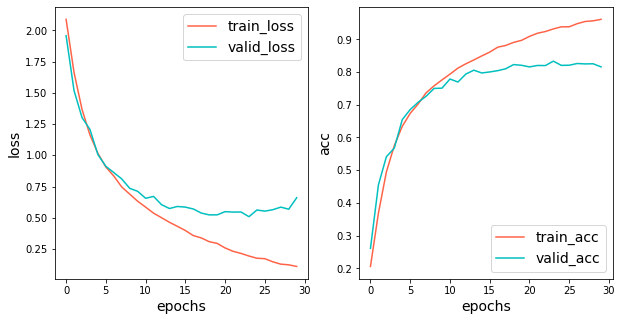

In [14]:
model = create_bench_model()
model.compile(loss = "categorical_crossentropy", 
              optimizer = Adam(), 
              metrics = ["accuracy"])
# .flow() numpyデータとラベルの配列を受け取り，拡張/正規化したデータのバッチを生成する
train_gen = ImageDataGenerator().flow(x_train,y_train, batch_size)
val_gen = ImageDataGenerator().flow(x_test,y_test, batch_size)
history = model.fit(train_gen,
                    epochs=epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_gen,
                    validation_steps=validation_steps)

### 評価と保存
my_eval(model, x_test, y_test)
loss_and_acc(history, "bench")
model.save(data_dir + "first_bench.hdf5")

#### Data Augmentation

訓練画像に変換を加えることでデータを水増しし、汎化性能を向上させる方法

In [15]:
def DataAugmentation_generator():
    return ImageDataGenerator(rotation_range=20, 
                              horizontal_flip=True, 
                              height_shift_range=0.2,
                              width_shift_range=0.2,
                              zoom_range=0.2,
                              channel_shift_range=0.2).flow(x_train, 
                                                            y_train,
                                                            batch_size)

In [16]:
model = create_bench_model()
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(),
              metrics=["accuracy"])
val_gan = ImageDataGenerator().flow(x_train, y_train, batch_size)
history = model.fit(DataAugmentation_generator(),
                     epochs=epochs,
                     steps_per_epoch=steps_per_epoch,
                     validation_data=val_gen,
                     validation_steps=validation_steps)
my_eval(model, x_train, y_train)

Epoch 1/30
100/100 [==============================] - 25s 241ms/step - loss: 2.1838 - accuracy: 0.1619 - val_loss: 1.9091 - val_accuracy: 0.2784
Epoch 2/30
100/100 [==============================] - 24s 236ms/step - loss: 1.8723 - accuracy: 0.2845 - val_loss: 1.6181 - val_accuracy: 0.4103
Epoch 3/30
100/100 [==============================] - 24s 238ms/step - loss: 1.7108 - accuracy: 0.3622 - val_loss: 1.4812 - val_accuracy: 0.4588
Epoch 4/30
100/100 [==============================] - 24s 241ms/step - loss: 1.5373 - accuracy: 0.4311 - val_loss: 1.3906 - val_accuracy: 0.4729
Epoch 5/30
100/100 [==============================] - 24s 238ms/step - loss: 1.4022 - accuracy: 0.4843 - val_loss: 1.3049 - val_accuracy: 0.5123
Epoch 6/30
100/100 [==============================] - 24s 235ms/step - loss: 1.2991 - accuracy: 0.5283 - val_loss: 1.1832 - val_accuracy: 0.5778
Epoch 7/30
100/100 [==============================] - 24s 235ms/step - loss: 1.2659 - accuracy: 0.5447 - val_loss: 1.0874 - val_ac

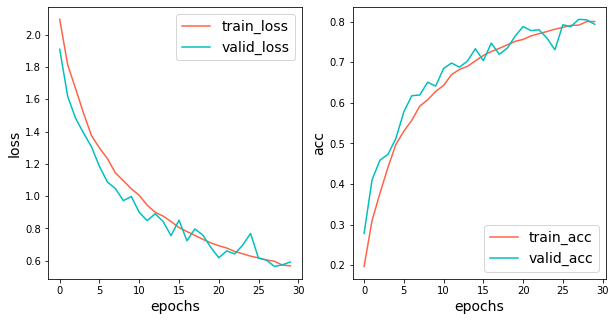

In [21]:
loss_and_acc(history,"DA")
model.save(data_dir + "DA.hdf5")

#### 層を増やす

訓練データの複雑さに対して、モデルの表現力が足りていない可能性が考えられえる。

In [22]:
def create_deep_model():
    inputs = Input(shape = (32,32,3))

    x = Conv2D(64,(3,3),padding = "SAME",activation= "relu")(inputs)
    x = Conv2D(64,(3,3),padding = "SAME",activation= "relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(64,(3,3),padding = "SAME",activation= "relu")(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128,(3,3),padding = "SAME",activation= "relu")(x)
    x = Conv2D(128,(3,3),padding = "SAME",activation= "relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(128,(3,3),padding = "SAME",activation= "relu")(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.25)(x)

    x = Conv2D(256,(3,3),padding = "SAME",activation= "relu")(x)
    x = Conv2D(256,(3,3),padding = "SAME",activation= "relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(256,(3,3),padding = "SAME",activation= "relu")(x)
    x = Conv2D(256,(3,3),padding = "SAME",activation= "relu")(x)
    x = Conv2D(256,(3,3),padding = "SAME",activation= "relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(512,(3,3),padding = "SAME",activation= "relu")(x)
    x = Conv2D(512,(3,3),padding = "SAME",activation= "relu")(x)
    x = GlobalAveragePooling2D()(x)

    x = Dense(1024,activation = "relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024,activation = "relu")(x)
    x = Dropout(0.5)(x)
    y  = Dense(10,activation = "softmax")(x)
    return Model(inputs,y)

In [23]:
model = create_deep_model()
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(),
              metrics=["accuracy"])
model.summary()
val_gan = ImageDataGenerator().flow(x_train, y_train, batch_size)
history = model.fit(DataAugmentation_generator(),
                     epochs=epochs,
                     steps_per_epoch=steps_per_epoch,
                     validation_data=val_gen,
                     validation_steps=validation_steps)
my_eval(model, x_train, y_train)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 16, 16, 64)        0   

In [24]:
def step_decay(epoch):
    lr = 0.001
    if(epoch >= 100):
        lr/=5
    if(epoch>=140):
        lr/=2
    return lr

In [26]:
model = create_deep_model()
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(),
              metrics=["accuracy"])
model.summary()
val_gan = ImageDataGenerator().flow(x_train, y_train, batch_size)
lr_decay = LearningRateScheduler(step_decay)
history = model.fit(DataAugmentation_generator(),
                     epochs=epochs,
                     steps_per_epoch=steps_per_epoch,
                     validation_data=val_gen,
                     validation_steps=validation_steps)
my_eval(model, x_train, y_train)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 16, 16, 64)        0   

In [27]:
model.save(data_dir + "lr_decay.hdf5")